In [1]:
cd /content/drive/MyDrive/hack

/content/drive/MyDrive/hack


In [2]:
# !unzip xview2.zip

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
import pathlib
dataset_path = "/content/drive/MyDrive/hack/test/"
train_data_dir = pathlib.Path(dataset_path+"images/")
test_data_dir = pathlib.Path(dataset_path+"test/")

train_files = glob.glob(r""+dataset_path+"images/"+"*.png")
train_files = list(filter(lambda x: "post" in x, train_files))
# train_files = random.sample(train_files, 1500)
train_datasize = len(train_files)
print("training data:", len(train_files))

test_files = glob.glob(r""+dataset_path+"test/"+"*.png")
test_files = list(filter(lambda x: "post" in x, test_files))
# test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("test data:", len(test_files))

training data: 926
test data: 7


1024
1024


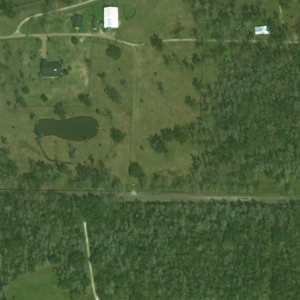

In [5]:
images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()

In [6]:
img_height = 1024
img_width = 1024
class_names = np.array(['no damage', 'minor damage', 'major damage', 'destroyed'])
print(class_names)

['no damage' 'minor damage' 'major damage' 'destroyed']


In [7]:
def get_label(file_path, type):
    parts = file_path.split(os.path.sep)

    path = dataset_path+'labels/'
    if type == "test":
        path = dataset_path+'labels/'
    f = open(path + parts[7].split('.')[0] +'.json')
    data = json.load(f)

    building_list = data["features"]["xy"]
    total_damage_level = 0 
    for i in range(len(building_list)):
      building = building_list[i]
      damage_level = building['properties']['subtype']
      if damage_level == 'no-damage':
        total_damage_level += 0
      elif damage_level == 'minor-damage':
        total_damage_level += 1
      elif damage_level == 'major-damage':
        total_damage_level += 2
      else:
        total_damage_level += 3
    f.close()
    
    average_damage_level = total_damage_level
    if len(building_list) > 0:
      average_damage_level /= len(building_list)

    label = class_names[round(average_damage_level)] == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot


def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [8]:
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img= PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("train")
print(train_X.shape)
print(train_Y.shape)


train
(926, 1024, 1024, 3)
(926, 4)


In [9]:

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img= PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("test")
print(test_X.shape)
print(test_Y.shape)

test
(7, 1024, 1024, 3)
(7, 4)


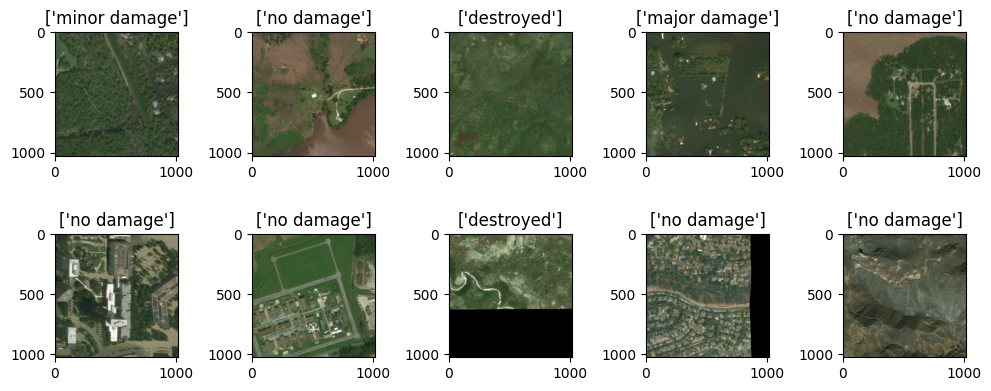

In [10]:
plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(5,5,i+1)    
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax"),
])

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1

In [18]:
epochs = 5
batch_size = 5


In [19]:
history = model.fit(
  train_X,
  train_Y,
  validation_data=(test_X, test_Y),
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/5
186/186 [==============================] - 2220s 12s/step - loss: 1.1518 - accuracy: 0.5832 - val_loss: 1.1234 - val_accuracy: 0.5714
Epoch 2/5
186/186 [==============================] - 2230s 12s/step - loss: 1.1620 - accuracy: 0.6102 - val_loss: 1.0149 - val_accuracy: 0.5714
Epoch 3/5
186/186 [==============================] - 2242s 12s/step - loss: 0.8721 - accuracy: 0.6911 - val_loss: 1.0632 - val_accuracy: 0.5714
Epoch 4/5
186/186 [==============================] - 2241s 12s/step - loss: 0.3624 - accuracy: 0.8855 - val_loss: 1.7003 - val_accuracy: 0.5714
Epoch 5/5
186/186 [==============================] - 2242s 12s/step - loss: 0.1814 - accuracy: 0.9546 - val_loss: 2.7417 - val_accuracy: 0.5714


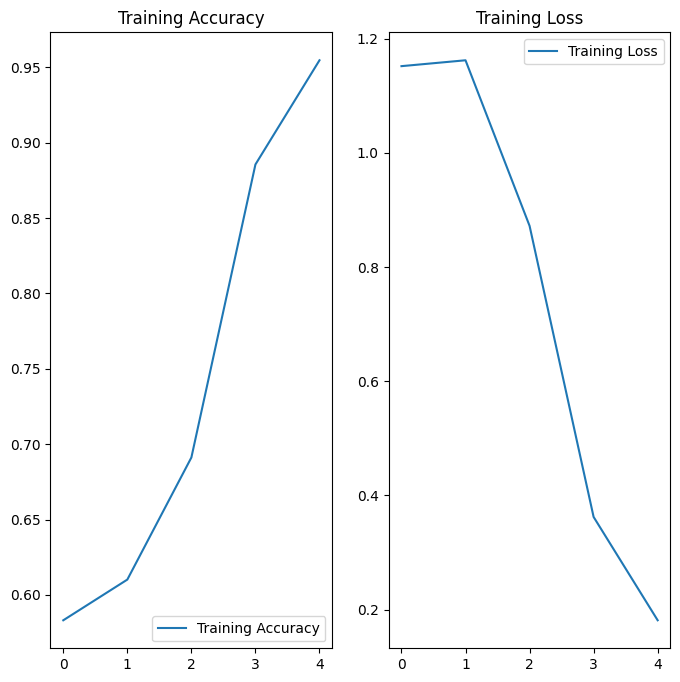

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [24]:
print(acc[-1])


0.9546436071395874


In [16]:
model.save("regional-damage-classification-model")